<a href="https://colab.research.google.com/github/Emersonmiady/rg-bank/blob/main/rgbank_trainee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# **RGBank: análise de riscos com Data Science**
---
---




![](https://raw.githubusercontent.com/Emersonmiady/rg-bank/main/img/credit_card.jpg)

---
## **Escopo do projeto**


Estou montando uma fintech chamada de **RGBank**, nela irei introduzir o serviço de **análise de risco**. Nesse serviço, nós iremos verificar a veracidade das transações feitas nas contas de nossos clientes. Para isso preciso de uma **análise descritiva** dos dados que possuo, para entender a situação da base de dados que coletei, além de alguns **modelos que classificam como fraude ou não a transação**, assim como qual é o melhor deles para ser
utilizado.
Além disso, possuo uma **estratégia de negócio** que deve ser levada em consideração
durante os cálculos das estimativas. Ela funciona da seguinte forma:
1. **A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.**
2. **A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.** 
3. **A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.**

Além disso, será necessário entregar um relatório reportando a **performance** e os **resultados** do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:
- **Qual a Precisão e Acurácia dos modelos utilizados?**
- **Qual dos modelos é o melhor e porquê?**
- **Qual o Faturamento Esperado pela Empresa, se classificarmos 100% das transações, com o melhor modelo?**
- **Qual o Prejuízo Esperado pela Empresa, se classificarmos 100% das transações, em caso de falha do melhor modelo?**
- **Qual o Lucro Esperado pela empresa, se classificarmos 100% das transações, ao utilizar o melhor modelo?** 

**Observação:** o relatório não será feito nesse notebook, mas as perguntas serão respondidas da mesma forma neste.

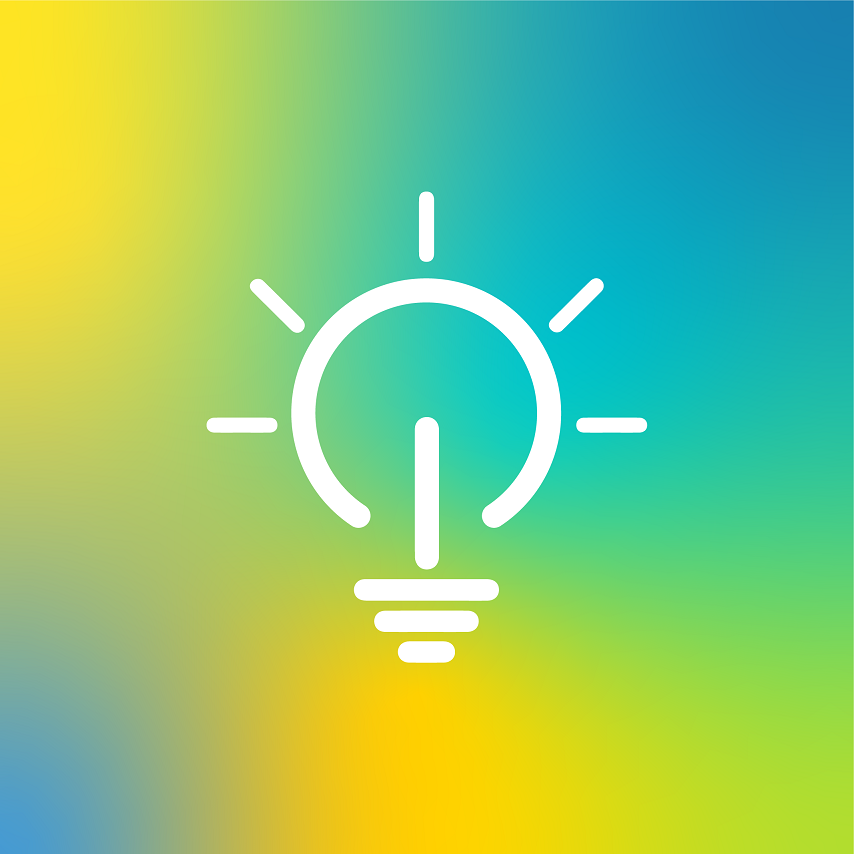

**Autores do trabalho:**
- **Emerson Hideki miady**
- **Luis Miguel**

---
## **Um pouco sobre o projeto**

### **Montando o Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Bibliotecas utilizadas**

In [ ]:
# Bibliotecas até EDA
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Bibliotecas de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import  roc_auc_score

%matplotlib inline

### **Algumas funções utilizadas**

In [ ]:
# Função para alterar a medida de potencia (e) no DataFrame
def change_float_format(switch=True):
  if switch == True:
    pd.options.display.float_format = '{:.2f}'.format
  else:
    pd.reset_option('^display.', silent=True)

In [ ]:
# Função para dar a matriz de confusão e uma versão dela com string
# Motivo: melhorar a visualização dos valores no sns.heatmap, 
# sem arredondamentos
def give_cm_2d_str_elements(y_test, y_pred, normalize=None):
  cm = confusion_matrix(y_test, y_pred, normalize=normalize)

  str_confusion_matrix = [[str(cm[0, 0]), str(cm[0, 1])], 
                          [str(cm[1, 0]), str(cm[1, 1])]]
  str_confusion_matrix = np.array(str_confusion_matrix)

  return cm, str_confusion_matrix

In [ ]:
# Função para mostrar a acurácia e a matriz de confusão 
# (normalizada e não)
def show_accuracy_and_confusion_matrix(model, y_test, y_pred):
  print(f'Acurácia: {accuracy_score(y_test, y_pred)}\n')

  cm1, str_cm_1 = give_cm_2d_str_elements(y_test, y_pred)

  cm2, str_cm_2 = give_cm_2d_str_elements(y_test, y_pred, 
                                        normalize='true')
  
  cm3, str_cm_3 = give_cm_2d_str_elements(y_test, y_pred, 
                                          normalize='pred')

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

  sns.heatmap(cm1, annot=str_cm_1, ax=ax1, fmt='s', 
              annot_kws={'fontsize':12}, cmap='Blues')
  ax1.set_title('Matriz de confusão não normalizada\n', 
                fontsize=12)
  ax1.set_xlabel('Valores preditos', fontsize=12)
  ax1.set_ylabel('Valores reais', fontsize=12)

  sns.heatmap(cm2, annot=str_cm_2, ax=ax2, vmin=0, vmax=1, fmt='s', 
              annot_kws={'fontsize':12}, cmap='Blues')
  ax2.set_title('Matriz de confusão normalizada em relação aos valores reais\n', 
                fontsize=12)
  ax2.set_xlabel('Valores preditos', fontsize=12)
  ax2.set_ylabel('Valores reais', fontsize=12)

  sns.heatmap(cm3, annot=str_cm_3, ax=ax3, vmin=0, vmax=1, fmt='s', 
              annot_kws={'fontsize':12}, cmap='Blues')
  ax3.set_title('Matriz de confusão normalizada em relação aos valores preditos\n', 
                fontsize=12)
  ax3.set_xlabel('Valores preditos', fontsize=12)
  ax3.set_ylabel('Valores reais', fontsize=12)

  plt.show()

In [ ]:
# Função para entregar algumas medidas do modelo
def give_ml_stats(model, y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  predict_proba = model.predict_proba(X_test)
  auc = roc_auc_score(y_test, predict_proba[:, 1])

  cm = confusion_matrix(y_test, y_pred)
  tn = cm[0, 0]
  fp = cm[0, 1]
  fn = cm[1, 0]
  tp = cm[1, 1]
  
  ml_stats = {'True Negative' : tn, 
              'False Positive' : fp, 
              'False Negative' : fn, 
              'True Positive' : tp, 
              'Accuracy' : accuracy, 
              'Precision' : precision, 
              'Recall' : recall, 
              'F1-Score' : f1, 
              'AUC' : auc}

  return ml_stats

In [ ]:
# Função para retornar o array com y_test e y_pred
def give_test_and_pred_array(model, X, y):
  y_pred = model.predict(X)
  test_and_pred = np.array([y, y_pred]).T
  return test_and_pred

In [ ]:
# Função para adquirir o montante para a RGBank
def give_cross_amount(model, X, y):
  test_and_pred = give_test_and_pred_array(model, X, y)

  tp_condition = (test_and_pred[:, 0] == 1) & (test_and_pred[:, 0] == test_and_pred[:, 1])
  fp_condition = (test_and_pred[:, 1] == 1) & (test_and_pred[:, 0] != test_and_pred[:, 1])

  cross_amount = np.sum(X[tp_condition, 1]) * 0.25 + np.sum(X[fp_condition, 1]) * 0.05
  
  return cross_amount

In [ ]:
# Função para adquirir as despesas para a RGBank
def give_expense(model, X, y):
  test_and_pred = give_test_and_pred_array(model, X, y)

  fn_condition = (test_and_pred[:, 1] == 0) & (test_and_pred[:, 0] != test_and_pred[:, 1])

  expense = np.sum(X[fn_condition, 1])

  return expense

In [ ]:
# Função para retornar os resultados de negócio para a RGBank
def give_business_results(model, X, y):
  cross_amount = give_cross_amount(model, X, y)
  expense = give_expense(model, X, y)
  gain = cross_amount - expense 
  
  return cross_amount, expense, gain

### **Informações dos dados utilizados**

Este conjunto de dados simula transações de dinheiro por celulares com base em uma amostra de transações reais extraídas de um mês de registros financeiros de um serviço de dinheiro móvel implementado em um país africano. Os dados originais foram fornecidos por uma empresa multinacional, que é a provedora do serviço financeiro móvel que atualmente opera em mais de 14 países em todo o mundo. Este conjunto de dados sintético é reduzido em 1/4 do conjunto de dados original.

PaySim first paper of the simulator: E. A. Lopez-Rojas, A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud
detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus.
2016

**Variáveis presentes e suas definições (inglês):**
- `step` - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps
744 (31 days simulation).
- `type` - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- `amount` - amount of the transaction in local currency.
- `nameOrig` - customer who started the transaction
- `oldbalanceOrg` - initial balance before the transaction
- `newbalanceOrig` - new balance after the transaction
- `nameDest` - customer who is the recipient of the transaction
- `oldbalanceDest` - initial balance recipient before the transaction. Note that there is not
information for customers that start with M (Merchants).
- `newbalanceDest` - new balance recipient after the transaction. Note that there is not
information for customers that start with M (Merchants).
- `isFraud` - This is the transactions made by the fraudulent agents inside the simulation. In this
specific dataset the fraudulent behavior of the agents aims to profit by taking control or 
customers accounts and try to empty the funds by transferring to another account and then
cashing out of the system.
- `isFlaggedFraud` - The business model aims to control massive transfers from one account to
another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer
more than 200.000 in a single transaction.

---
## **Análise dos dados**

In [ ]:
# Mudando o formato dos números para melhorar a visualização
change_float_format()

#### **Informações básicas do dataframe**

Antes de começarmos a nossa análise, vamos dar uma olhada como é a cara do nosso DataFrame.

In [ ]:
# Mostrando as 5 primeiras linhas
df = pd.read_csv('/content/drive/Shareddrives/RGBank/RGBank.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [ ]:
# Dimensão do DataFrame
print(f'Esse arquivo .csv possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

Esse arquivo .csv possui 6362620 linhas e 11 colunas.


In [ ]:
# Vendo os tipos das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### **Pré-processamento dos dados**

#### **Verificação de dados faltantes**

Verificar se existem *missing data* é muito importante, principalmente porque os nossos modelos de *machine learning* não conseguem processá-los...

Então vai abaixo os dados faltates, por coluna, do nosso DataFrame.

In [ ]:
# Dados faltantes de cada coluna
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Pelo visto não existem dados faltantes, certo?

Na verdade, eles estão escondidos... pela descrição, nas variáveis `oldbalanceDest` e `newbalanceDest`, aqueles demarcados como "M" ("*Merchants*" = comerciantes) em `nameDest`, estão com valores iguais a 0. 

Sendo assim, é óbvio que não existam *missing data*. Portanto, devemos transformá-los em algum outro valor, e a melhor opção que o nosso grupo chegou, foi trocá-los pela **mediana** dos **não comerciantes**.

#### **Trocando valores**

##### ***Missing Data***

Antes, vamos dividir o nosso *DataFrame* em "comerciantes" e "não comerciantes" como destinatários. 

Logo após esse passo, calculamos a mediana das variáveis `oldbalanceDest` e `newbalanceDest`, no *DataFrame* dos "não comerciantes", e trocamos no outro *DataFrame*. Enfim, vamos para a prática!

In [ ]:
# Definindo uma nova coluna para demarcar diferenças entre mercadores e 
# não, como destinatários.
merchant_dest_df_bool = df['nameDest'].str.startswith('M')
is_merchant = []

for merchant in merchant_dest_df_bool:
  if merchant == True:
    is_merchant.append(1)
  else:
    is_merchant.append(0)

In [ ]:
df['isMerchantDest'] = is_merchant
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,1


In [ ]:
merchant_dest_df = df.query('isMerchantDest == 1')
not_merchant_dest_df = df.query('isMerchantDest == 0')

In [ ]:
# Mostrando os DataFrames separadamente
print('Prévia do Dataframe dos comerciantes como destinatários:\n')
display(merchant_dest_df.head(3))
print('\n\n')
print('Prévia do Dataframe dos que não são comerciantes como destinatários:\n')
display(not_merchant_dest_df.head(3))

Prévia do Dataframe dos comerciantes como destinatários:



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,1





Prévia do Dataframe dos que não são comerciantes como destinatários:



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.00,40348.79,0,0,0


In [ ]:
# Recolhendo a mediana dos não comerciantes
not_merchant_dest_old_balance_median = not_merchant_dest_df['oldbalanceDest'].median()
print(f'Mediana de oldbalanceDest dos não comerciantes como destinatário: {not_merchant_dest_old_balance_median}\n')

not_merchant_dest_new_balance_median = not_merchant_dest_df['newbalanceDest'].median()
print(f'Mediana de newbalanceDest dos não comerciantes como destinatário: {not_merchant_dest_new_balance_median}')

Mediana de oldbalanceDest dos não comerciantes como destinatário: 551247.21

Mediana de newbalanceDest dos não comerciantes como destinatário: 683724.79


In [ ]:
# Definindo os valores no outro DataFrame
merchant_dest_df.loc[:, 'oldbalanceDest'] = not_merchant_dest_old_balance_median
merchant_dest_df.loc[:, 'newbalanceDest'] = not_merchant_dest_new_balance_median

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Agora, finalmente, vamos juntar tudo!

In [ ]:
df = merchant_dest_df.append(not_merchant_dest_df)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,551247.21,683724.79,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,551247.21,683724.79,0,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,551247.21,683724.79,0,0,1
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,551247.21,683724.79,0,0,1
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,551247.21,683724.79,0,0,1


In [ ]:
# Deletando os dfs para não sobrecarregar o Colab
del [merchant_dest_df, not_merchant_dest_df]

##### **Variável "*step*"**

Pela descrição, a variável `step` é a contagem de horas até dar 31 dias. Sendo assim, um `step` igual a 1, por exemplo, significa que se passou 1 hora desde o começo da coleta de amostras de transações.

Nesse contexto, conseguimos separá-las de uma forma bem mais intuitiva para nós, seres humanos. Vamos dividí-la em 2 outras colunas, uma que irá mostrar o **dia no mês** (`day`) e a **respectiva hora** (`hour`) em que a operação foi feita.

In [ ]:
# coletando os dados do dia e hora
hours = df['step']
total_days = []
hours_in_day = []
for step in hours:
  if (step % 24) == 0:
    total_days.append(step / 24)
    hours_in_day.append(24)
  else:
    total_days.append(step // 24)
    hours_in_day.append(step % 24)

Preferimos colocar as colunas no lugar da `step`, ou seja, na mesma ordem em que esta aparecia antes (primeira variável).

In [ ]:
# Definindo uma ordem para as colunas
new_cols = ['hour', 'day']
columns = list(df.columns)

columns = new_cols + columns
print(columns)

['hour', 'day', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'isMerchantDest']


In [ ]:
# Reordenando as colunas
df['hour'] = None
df['day'] = None

df = df[columns]
df['hour'] = hours_in_day
df['day'] = total_days
df.drop('step', axis=1, inplace=True)

In [ ]:
# Alocando valores para as novas informações
df['hour'] = hours_in_day
df['day'] = total_days

In [ ]:
df.head()

,hour,day,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest
0,1,0.00,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,551247.21,683724.79,0,0,1
1,1,0.00,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,551247.21,683724.79,0,0,1
4,1,0.00,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,551247.21,683724.79,0,0,1
5,1,0.00,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,551247.21,683724.79,0,0,1
6,1,0.00,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,551247.21,683724.79,0,0,1


In [ ]:
# Deletando as variáveis desnecessárias que sobraram 
# para não sobrecarregar o Colab
del [hours, hours_in_day, total_days]

### **Análise Exploratória dos dados**

**Qual o nosso objetivo?**

Queremos entender como são os dados quando eles são fraudulentos e legítimos, ou seja, **analisaremos as variáveis de acordo com a coluna `isFraud`**. 

Desse modo, verificaríamos se, existe uma diferença entre os dois casos, e futuramente, se existissem características que se assemelham com as fraudulentas, seria apenas um alerta para determinada amostra.

In [ ]:
# Mudando o formato para ver os proporções das variáveis categóricas
change_float_format(switch=False)

#### **Proporção de fraudes**

In [ ]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
df['isFraud'].value_counts(normalize=True) * 100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

Perceba - como esperado - que as operações fraudulentas são poucas em relação as licitas. São cerca de **0,12%** do total das operação.

#### **"*isMerchantDest*" fraudadores?**

In [ ]:
pd.crosstab(index=df['isMerchantDest'], columns=df['isFraud'])

isFraud,0,1
isMerchantDest,,
0,4202912,8213
1,2151495,0


Aqui vemos que **nenhuma** operação relacionada com mercadores são consideradas fraudes. Vamos dar uma olhada no tipo de operações feitas por *Merchants* para termos uma ideia do porque essa classe não possui operações consideradas fraudes.

In [ ]:
pd.crosstab(index=df['isMerchantDest'], columns=df['type'])

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
isMerchantDest,,,,,
0,1399284,2237500,41432,0,532909
1,0,0,0,2151495,0


Veja aqui que os *Merchant* apenas praticam operações do tipo **PAYMENT**, talvez essa seja uma modalidade menos suscetivel a fraudes por questões de segurança ou as fraudes são mais dificeis de serem detectadas ou os *Merchant* utilizam essa unica forma de transação por questões socioeconômicas do país análisado.

#### **Tipos de transações**

Vamos dar uma olhada agora nos tipos de transações que mais possuem fraudes detectadas.

In [ ]:
pd.crosstab(index=df['type'], columns=df['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [ ]:
pd.crosstab(index=df['type'], columns=df['isFraud'], normalize='index')

isFraud,0,1
type,,
CASH_IN,1.000000,0.000000
CASH_OUT,0.998160,0.001840
DEBIT,1.000000,0.000000
PAYMENT,1.000000,0.000000
TRANSFER,0.992312,0.007688


In [ ]:
pd.crosstab(index=df['type'], columns=df['isFraud'], normalize='columns')

isFraud,0,1
type,,
CASH_IN,0.220207,0.000000
CASH_OUT,0.351470,0.501157
DEBIT,0.006520,0.000000
PAYMENT,0.338583,0.000000
TRANSFER,0.083220,0.498843


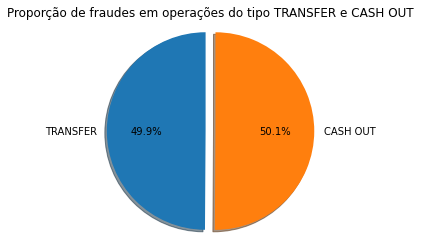

In [ ]:
labels = 'TRANSFER','CASH OUT'
sizes = [49.9, 50.1]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax2 = plt.subplots()
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proporção de fraudes em operações do tipo TRANSFER e CASH OUT')
plt.show()

Veja aqui que as fraudes concentram-se em apenas duas modalidades de transações financeiras, CASH_OUT, com **50.1%** do total de fraudes e TRANSFER, com **49.9%** do total de fraudes. A hipótese que visa explicar o porque dessas operações serem não só as mais comuns, mas as unicas que possuem evidências de fraudes, são porque envolvem **roubo de dados e clonagem de cartão** no caso de CASH_OUT ou **persuasão**, no caso de TRANSFER, quando o criminoso convence a vítima a realizar transfências para sua conta. 
De acordo com a folha de São Paulo, em matéria que pode ser acessada através [deste link](https://agora.folha.uol.com.br/grana/2020/09/conheca-os-7-principais-golpes-bancarios-e-saiba-como-evita-los.shtml), existem 7 principais métodos de golpes ou fraudes bancárias.

1 - Envio de links falsos, que é a "pescaria digital": o criminoso utiliza links e perfis falsos para roubar dados e informações das vítimas.

Geralmente, os fraudadores enviam as mensagens se passando pela instituição financeira e usam tom alarmista para se comunicar. Por exemplo: "seu cartão está bloqueado. Clique aqui para atualizar seus dados e desbloquear".

2 - Falso funcionário: o fraudador entra em contato com a pessoa, fingindo ser funcionário de algum banco. Ele diz que há problemas de cadastro ou irregularidades na conta. Com o argumento de que vai solucionar a situação, pede os dados da vítima e, em seguida, realiza transações fraudulentas

3 - Falso motoboy: a quadrilha liga para a vítima e diz ser da central de atendimento do banco. Informa que houve problemas com o cartão e pede ao cliente que digite sua senha numérica no teclado do telefone. O golpista diz que irá enviar um motoboy à casa da vítima para pegar o cartão. Com o cartão e a senha em mãos, a quadrilha efetua transações

4 - Ajuda falsa: em caixas eletrônicos ou agências bancárias, os criminosos abordam as vítimas para oferecer uma suposta ajuda. Em um momento de distração do cliente, o golpista troca o cartão ou o envelope de depósito por outro vazio

5 - Troca de cartões: durante o pagamento com cartões, o criminoso consegue ver a senha digitada. A vítima é distraída e o golpista troca o cartão por outro semelhante

6 - Extravio de cartões: em alguns casos, as quadrilhas conseguem ter acesso ao trâmite de entrega do cartão ao cliente por correspondência. Os fraudadores interceptam a entrega e ligam para a vítima a fim de comunicá-la sobre um problema. Para solucionar a suposta falha, solicitam a senha do cartão, com a qual podem efetuar compras e pagamentos

7 - Golpe do WhatsApp: o golpista cadastra o número telefônico da pessoa a ser atacada em seu celular e entra em contato com ela, se passando por um funcionário de alguma empresa com a qual o cliente tenha relacionamento. Ele diz que a vítima vai receber um código e pede que esse código seja enviado a ele. Assim, o fraudador tem acesso ao WhatsApp da vítima e começa a mandar mensagem para os contatos solicitando dinheiro

Perceba que desses 7 principais metodos, todos envolvem operações do tipo CASH_OUT ou TRANSFER.

#### **Número de fraudes por dia**

In [ ]:
dfday = pd.crosstab(index=df['day'], columns=df['isFraud'])
dfday

isFraud,0,1
day,,
0.0,570774,265
1.0,452456,305
2.0,6443,306
3.0,21632,272
4.0,12751,244
5.0,440396,230
6.0,420002,280
7.0,448877,270
8.0,417844,259


In [ ]:
print('Descrição do número de fraudes em 1 mês')
dfday.describe()

Descrição do número de fraudes em 1 mês


isFraud,0,1
count,31.000000,31.000000
mean,204980.870968,264.935484
std,205092.767603,22.485455
min,0.000000,220.000000
25%,16879.500000,250.000000
50%,54775.000000,265.000000
75%,417791.000000,276.000000
max,570774.000000,316.000000


Perceba que temos em média **264.94** fraudes bancárias por dia com uma mediana de **265** casos. Os casos nunca foram menores que 220 e nunca ultrapassaram 316 casos em um unico dia.

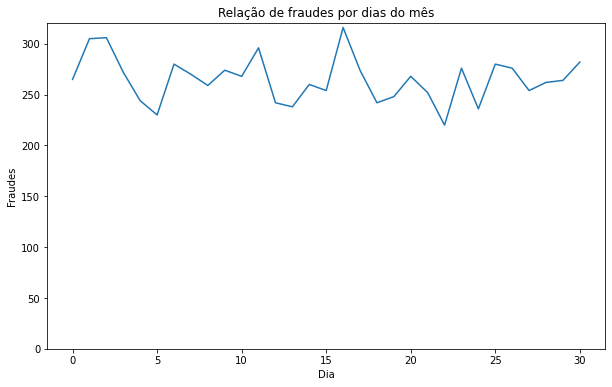

In [ ]:
plt.figure(figsize = (10,6))
sns.lineplot(x = dfday.index, y = 1, data = dfday)
plt.ylim(0)
plt.ylabel('Fraudes')
plt.xlabel('Dia')
plt.title('Relação de fraudes por dias do mês')
plt.show()

É possivel ver pelo gráfico acima que que há dois picos de observações, um do dia *1* ao *2* e outro do dia *15* ao *16*, com uma tendência de alta no final do mês.

#### **Número de fraudes por hora**

In [ ]:
dfhour = pd.crosstab(index=df['hour'], columns=df['isFraud'])
dfhour

isFraud,0,1
hour,,
1,26753,358
2,8646,372
3,1681,326
4,967,274
5,1275,366
6,3062,358
7,8660,328
8,26547,368
9,283177,341


In [ ]:
print('Descrição do número de fraudes em 24 horas')
dfhour.describe()

Descrição do número de fraudes em 24 horas


isFraud,0,1
count,24.000000,24.000000
mean,264766.958333,342.208333
std,225698.950462,22.521447
min,967.000000,274.000000
25%,22075.250000,336.250000
50%,265318.000000,344.000000
75%,442367.250000,354.250000
max,647472.000000,375.000000


Analisando as fraudes por hora vemos que há uma média de **342,2** fraudes por hora com uma mediana de **344** fraudes por hora. Também notamos que nunca há menos que 274 fraude e mais que 375. 

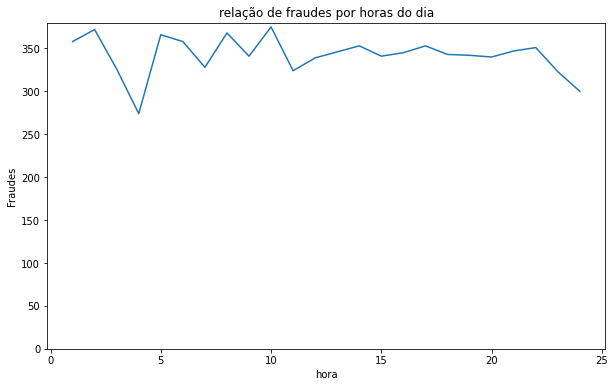

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=dfhour.index, y=1, data=dfhour)
plt.ylim(0)
plt.xlabel('hora')
plt.ylabel('Fraudes')
plt.title('relação de fraudes por horas do dia')
plt.show()

Podemos notar que as fraudes picos nas **2 primeiras horas** do dia e das **5 às 10h da manhã**. Talvez tenha alguma relação com a quantidade de tipos de operações financeiras feitas por hora. Olhemos:

In [ ]:
dfhourtype = pd.crosstab(index=df['hour'], columns=df['type'])
dfhourtype

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
hour,,,,,
1,4855,3898,1136,15115,2107
2,2355,1256,449,4292,666
3,417,432,58,752,348
4,230,277,26,473,235
5,302,373,29,678,259
6,609,517,51,1856,387
7,1403,1494,138,4905,1048
8,5136,7659,189,11288,2643
9,64337,94825,1566,97587,25203


Text(0.5, 1.0, 'Quantidade de transações financeiras por hora de acordo com o tipo da operação ')

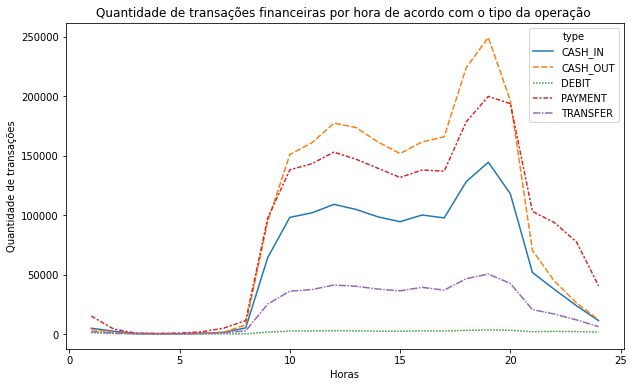

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=dfhourtype)
plt.ylabel('Quantidade de transações')
plt.xlabel('Horas')
plt.title('Quantidade de transações financeiras por hora de acordo com o tipo da operação ')

Podemos ver que os picos de transações fraudulentas não estão alocadas em horários que mais acontecem transações CASH_OUT e TRANSFER, com excessão do crescimento expressivo das 8 até às 10h.

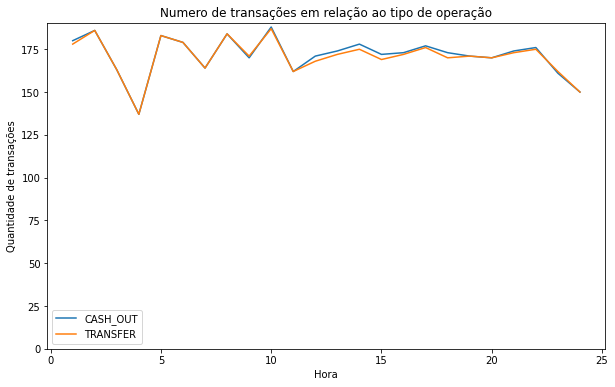

In [ ]:
dfhourtypefraud = pd.pivot_table(data=df, index=['hour'], values='isFraud', 
                            columns=['type'], aggfunc=np.sum)
plt.figure(figsize=(10, 6))
sns.lineplot(x=dfhourtypefraud.index, y='CASH_OUT', data=dfhourtypefraud,
             label='CASH_OUT')
sns.lineplot(x=dfhourtypefraud.index, y='TRANSFER', data=dfhourtypefraud,
             label='TRANSFER')
plt.title('Numero de transações em relação ao tipo de operação')
plt.ylabel('Quantidade de transações')
plt.xlabel('Hora')
plt.ylim(0)
plt.show()

Do último gráfico, temos que o número de transações fraudulentas CASH_OUT e TRANSFER andam com números muito próximos, no decorrer do dia.

#### **Analisando "*isFlaggedFraud"***

In [ ]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [ ]:
df['isFlaggedFraud'].value_counts(normalize=True) * 100

0    99.999749
1     0.000251
Name: isFlaggedFraud, dtype: float64

Perceba que temos poucas amostras de fraudes na coluna `isFlaggedFraud`, somente **16** evidencias. Isso pode implicar que não temos informações suficientes para tirarmos boas conclusões, porém, como todos os casos de fraudes detectadas são em transações do tipo TRANSFER e CASH_OUT, espera-se que essa variável tenha um comportamento parecido com a variável `isFraud`.

In [ ]:
pd.crosstab(index=df['type'], columns=df['isFlaggedFraud'])

isFlaggedFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2237500,0
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,532893,16


Como podemos ver, todas as ocorrências de fraude são em operações do tipo **TRANSFER** o que pode significar que a variável `isFraggedFraud` possui um comportamento muito parecido com a variavel `isFraud`, apesar de não ter nenhuma CASH_OUT.



In [ ]:
pd.crosstab(index=df['isMerchantDest'], columns=df['isFlaggedFraud'])

isFlaggedFraud,0,1
isMerchantDest,,
0,4211109,16
1,2151495,0


Perceba que não há um único *Merchant* que tenha operações do tipo fraude. O mesmo pode ser visto na variavel `isFraud` onde das mais de 8 mil detecções de fraude, nenhuma pertencia a *Merchant*.

In [ ]:
dfdayflagg = pd.crosstab(index=df['day'], columns=df['isFlaggedFraud'])
dfdayflagg

isFlaggedFraud,0,1
day,,
0.0,571039,0
1.0,452761,0
2.0,6749,0
3.0,21904,0
4.0,12995,0
5.0,440626,0
6.0,420282,0
7.0,449147,0
8.0,418102,1


In [ ]:
print('Descrição estatística do número de isFlaggedFraud em 1 mês')
dfdayflagg.describe()

Descrição estatística do número de isFlaggedFraud em 1 mês


isFlaggedFraud,0,1
count,31.000000,31.000000
mean,205245.290323,0.516129
std,205095.454696,0.769024
min,279.000000,0.000000
25%,17130.000000,0.000000
50%,55037.000000,0.000000
75%,418053.500000,1.000000
max,571039.000000,3.000000


Vemos aqui que a média de fraudes flagrantes é de **0.5** ocorrência por dia, sendo que o maximo identificado foi de **3 em um dia**.

In [ ]:
dfhourflagg = pd.crosstab(index=df['hour'], columns=df['isFlaggedFraud'])
dfhourflagg

isFlaggedFraud,0,1
hour,,
1,27111,0
2,9017,1
3,2006,1
4,1241,0
5,1641,0
6,3419,1
7,8988,0
8,26915,0
9,283518,0


In [ ]:
print('Descrição estatística do número de isFlaggedFraud em 24 horas')
dfhourflagg.describe()

Descrição estatística do número de isFlaggedFraud em 24 horas


isFlaggedFraud,0,1
count,24.000000,24.000000
mean,265108.500000,0.666667
std,225701.435104,1.049500
min,1241.000000,0.000000
25%,22440.500000,0.000000
50%,265661.500000,0.000000
75%,442707.000000,1.000000
max,647814.000000,4.000000


Quando comparada com a coluna hora, vemos que em média há **0.6** fraudes flagrantes por hora, sendo a ocorrencia máxima tendo ocorrido as 10h da manhã com **4 fraudes flagrantes**.

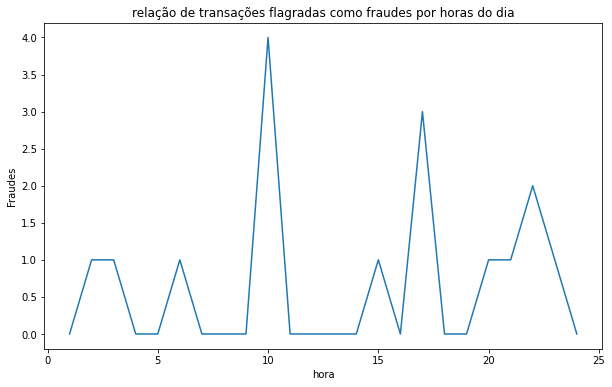

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=dfhourflagg[1])

plt.xlabel('hora')
plt.ylabel('Fraudes')
plt.title('relação de transações flagradas como fraudes por horas do dia')
plt.show()

É importante reiterar que não há uma quantidade significativa de dados na coluna `isFlaggedFraud` porém, aparentemente, essa variável possui um comportamento muito similar com a variável `isFraud`.

#### **Diferença entre os montantes**

Vamos investigar agora a variável `amount` em relação a variável `isFraud`. Aqui, nosso intuito é descobrir se há alguma relação entre o valor das operações financeiras com fraudes.

In [ ]:
# Mudando o formato para ver os proporções de amount
change_float_format()

In [ ]:
x = df.query('isFraud == 1')
y = df.query('isFraud == 0')

df_fraud_amount = pd.DataFrame(columns=['Describe', 'Not Fraud', 'Fraud'])
df_fraud_amount['Describe'] = x.describe()['amount'].index
df_fraud_amount.set_index('Describe', inplace=True)

df_fraud_amount['Not Fraud'] = y.describe()['amount'].values
df_fraud_amount['Fraud'] = x.describe()['amount'].values

In [ ]:
display(df_fraud_amount)

,Not Fraud,Fraud
Describe,,
count,6354407.00,8213.00
mean,178197.04,1467967.30
std,596236.98,2404252.95
min,0.01,0.00
25%,13368.40,127091.33
50%,74684.72,441423.44
75%,208364.76,1517771.48
max,92445516.64,10000000.00


Perceba que o valor minimo das transações fraudulentas é **0**, enquanto que o das operações licitas é **0.01**, ou seja, em nosso banco de dados, **todas as operações zeradas são fraudes**. o mesmo pode ser observado no valor máximo. As operações licitas **nunca ultrapassam 10.000.000** e a não fraudulentas ultrapassam esse valor chagando até 92.445.516,64, ou seja, toda transação que ultrapasse 10.000.000 não é fraudulenta em nosso *DataSet*.

Como esperado de um *dataset* de transações financeiras, em ambos os casos vemos um **desvio padrão grande** o que significa que os valores da amostra estão **bem dispersos em relação a média**, porém, como a mediana é **menor** que a média para ambos os casos, isso mostra que temos um caso de **assimetria negativa**, onde os valores estão bem concentrados à esquerda da média.

Perceba que no caso dos valores fraudulentos 25% das amostras consistem em valores até **127.091,33**, enquanto que nos não fraudulentos estão em **13.368,40**. O mesmo pode ser visto para os outros dois proximos quadrantes, ou seja, **as operações fraudulentas tendem a ter um `amount` maior que operações não fraudolentas**, claro que os dados possuem tamanhos bem diferentes, porém, espera-se em relação a fraudes, que elas tenham um valor significativamente maior que as lícitas. Podemos ter uma ideia melhor com o auxílio de um diagrama de caixa. Veja-o abaixo.

Text(0.5, 1.0, 'Montante em relação as fraudes')

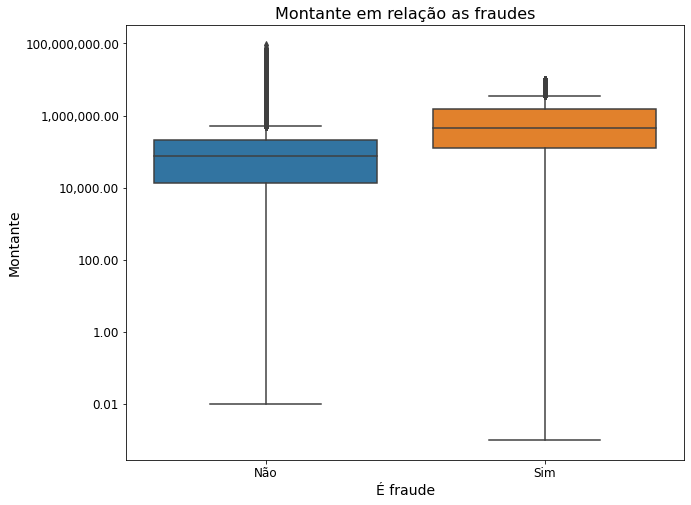

In [ ]:
dfg=df.copy()
dfg['amount'] = df['amount'].replace(0,0.001)

plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='isFraud', y='amount', data = dfg)
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
plt.ylabel('Montante', fontsize=14)
plt.xlabel('É fraude', fontsize=14)
plt.xticks([0, 1], ['Não', 'Sim'], fontsize=12)
plt.yticks(fontsize=12)
plt.title('Montante em relação as fraudes', fontsize=16)

Em nosso diagrama de caixa, como o valor de nossas amostram são muito altos, optamos por transfomá-los em logaritmo, para melhorar a visualização do gráfico. Só um aviso, não existe valor 0 na escala logaritmica, no entanto, transformamos todos os zeros para 0.001, assim conseguimos ter uma visão de todos os dados.

In [ ]:
# Deletando df_fraud_amount para não sobrecarregar o Colab
del df_fraud_amount

---
## **Machine Learning**

### **Excluindo algumas variáveis**

Agora está na hora de prevermos se a operação será fraude ou não. Para isso, antes de tudo, vamos excluir as colunas `nameOrig` e `nameDest`, pois não é relevante eu saber quem exatamente está fazendo as transações... não é produtivo, já que esperamos expandir isso para amostras **nunca** vistas.

In [ ]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [ ]:
df.head()

,hour,day,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest
0,1,0.00,PAYMENT,9839.64,170136.00,160296.36,551247.21,683724.79,0,0,1
1,1,0.00,PAYMENT,1864.28,21249.00,19384.72,551247.21,683724.79,0,0,1
4,1,0.00,PAYMENT,11668.14,41554.00,29885.86,551247.21,683724.79,0,0,1
5,1,0.00,PAYMENT,7817.71,53860.00,46042.29,551247.21,683724.79,0,0,1
6,1,0.00,PAYMENT,7107.77,183195.00,176087.23,551247.21,683724.79,0,0,1


### **Transformando em Dummies** 

Nosso próximo passo é realizar o processo de transformação das variáveis categóricas em ***dummies***. Assim temos as variáveis categóricas como parâmetro binário, ou seja, numéricos!

In [ ]:
# Transformando a coluna hour para categorias
df['hour'] = pd.Categorical(df['hour'])

In [ ]:
# Transformando em dummies
df = pd.get_dummies(df)
df.head()

,day,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.00,9839.64,170136.00,160296.36,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.00,1864.28,21249.00,19384.72,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.00,11668.14,41554.00,29885.86,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0.00,7817.71,53860.00,46042.29,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0.00,7107.77,183195.00,176087.23,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### **Dividindo nas variáveis independentes e dependente**

Ainda precisamos separar algumas variáveis no X (variáveis independentes), pois não apresentam algum significado produtivo para a modelagem! Além de obviamente, separar a nossa variável *target* (y).

In [ ]:
# Dividindo o nosso DataFrame em X e y
X = df.drop(['isFraud', 'isFlaggedFraud', 'isMerchantDest', 
             'type_PAYMENT', 'hour_24'], axis=1).values
                 
y = df['isFraud'].values

- Dropamos as culunas `isMerchantDest` e `type_PAYMENT` pois elas são redundantes! Como descobrimos que, ser comerciante como destinatário é o mesmo que ser do tipo "PAYMENT", e ser do tipo "PAYMENT" é ter todas as colunas "`type_(...)`" ZERADAS (tirando a própria "PAYMENT"), então `isMerchantDest` e `type_PAYMENT` não serão necessárias!

- Pelo mesmo motivo de ser redundante, ou seja, "todas as outras colunas de `hour_x` ZERADAS" ser equivalente a "`hour_24` igualada a 1", optamos por retirar a `hour_24`.

- Dropamos a coluna `isFlaggedFraud` pois não existe uma importância tão grande, já que o nosso próprio modelo deveria identificar se é fraude ou não, e não apenas com uma sinalização simples de que pode ser fraude com transações acima de 200.000... Não faz muito sentido deixar essa variável no modelo.

In [ ]:
# Prévia do X
print(X)

[[0.00000000e+00 9.83964000e+03 1.70136000e+05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.86428000e+03 2.12490000e+04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.16681400e+04 4.15540000e+04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.00000000e+01 6.31140928e+06 6.31140928e+06 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.00000000e+01 8.50002520e+05 8.50002520e+05 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [3.00000000e+01 8.50002520e+05 8.50002520e+05 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [ ]:
# Prévia do y
print(y)

[0 0 0 ... 1 1 1]


### **Separando em dados de treino e teste**

Está quase acabando a nossa preparação para os modelos, basta dividir o *dataset* em treino e teste e padronizá-los, para alguns algoritmos esta última é importate. 

Não existe uma resposta específica do quanto devemos dividir a base de dados, mas para o nosso caso, seria legal seguir a recomendação da comunidade de Data Science, ou seja, **20-80** ou **30-70**. Sendo assim, vamos optar pela divisão 20% para teste e 80% para treino.

Além disso, queremos um conjunto de teste **bem representativo** em relação aos dados de treino, sendo assim, acionamos o argumento `stratify=y`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, stratify=y)

### **Padronizando os dados**

Nesta última etapa, vamos apenas padronizar o nosso *dataset*. Isso porque não queremos que existam pesos muito altos, dependendo da escala de alguma determinada variável.

In [ ]:
# Estamos fazendo tanto na variável X de teste e na X de treino
sc = StandardScaler()
X_train[:, :5] = sc.fit_transform(X_train[:, :5])
X_test[:, :5] = sc.transform(X_test[:, :5])

### **Modelos possíveis**

Nesta seção, veremos alguns modelos de *machine learning* que foram testados no projeto. Cada algoritmo passará por uma visão geral em um primeiro instante, mostrando a **acurácia** e as **matrizes de confusão** (normalizadas e não normalizadas).

Depois disso, resumiremos algumas **métricas** (listadas abaixo no código) de cada modelo em um único *DataFrame*, e assim, compará-las, para decidir qual seria o melhor para o nosso RGBank!

- **Observação 1:** houve a tentativa de utilizar o K-NN, entretanto não foi possível, pois aparentemente, não houve suporte computacional para rodar o modelo...

In [ ]:
# Fazendo o DataFrame com as métricas
models_metrics = pd.DataFrame(columns=['True Negative', 'False Positive',
                                       'False Negative', 'True Positive',
                                       'Accuracy', 'Precision', 'Recall', 
                                       'F1-Score', 'AUC', 'Model'])

- **Observação 2:** vão aqui os significados das métricas que iremos utilizar:

  - ***Confusion Matrix***: é a tabela em que separamos os valores que são preditos corretamente ou não (colunas), de acordo com os dados de treino reais (linhas), vai uma figura explicativa:

  <center><img src='https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg' width=750></center>

  - ***True Negative (TN)***: *targets* iguais a **0** e que **foram** preditos corretamente;

  - ***False Positive (FP)***: *targets* iguais a **0** e que **não foram** preditos corretamente;

  - ***False Negative (FN)***: *targets* iguais a **1** e que **não foram** preditos corretamente;

  - ***True Positive (TP)***: *targets* iguais a **1** e que **foram** preditos corretamente;

  - ***Accuracy***: dentre todas as classificações, quantas o modelo classificou corretamente. É utilizado mais para ter uma performance geral:
\begin{eqnarray}\\
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
\end{eqnarray}

  - ***Precision***: dentre todas as classificações de **classe 1** que o **modelo fez**, quantas estão corretas. É usado em situações em que o **FP é mais prejudicial que FN**:
\begin{eqnarray}\\
Precision = \frac{TP}{TP + FP}
\end{eqnarray}

  - ***Recall***: dentre todas as situações de **classe 1** como **valor esperado**, quantas estão corretas. É usado em situações em que o **FN é mais prejudicial que FP**:
\begin{eqnarray}\\
Recall = \frac{TP}{TP + FN}
\end{eqnarray}

  - ***F1-Score***: é a média harmônica entre *precision* e *recall*. Mas basicamente, ela é sensível a valores muito pequenos, tanto da primeira medida quanto da segunda:
\begin{eqnarray}\\
F1 Score = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{eqnarray}

  - ***AUC***: é a probabilidade de que um exemplo positivo aleatório seja pontuado acima de um exemplo negativo aleatório. Então quanto maior a taxa de TP em relação a taxa de FP, maior é o AUC. Também existe a curva ROC, que explica melhor essa situação, e a AUC, dentro da curva ROC, é a área do gráfico:
    <center><img src='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fncss-wpengine.netdna-ssl.com%2Fwp-content%2Fuploads%2F2016%2F06%2FROC-Curve-2-Groups.png&f=1&nofb=1' width=600></center>

- **Observação 3:** não iremos nos adentrar tanto na questão técnica matemática na explicação dos modelos.

In [ ]:
# Resetando as configurações de .flutuante (para as nossas medidas)
change_float_format(switch=False)

#### ***Naive-Bayes***

O funcionamento deste algoritmo se dá pelo uso do **Teorema de Bayes**:
\begin{eqnarray}\\
P(A|B) = \frac{P(B|A) * P(A)}{P(B)}
\end{eqnarray}

Basicamente, o **A** seria a nossa variável *target* (y) quando ela é igual a uma determinada label, e o **B** todas as variáveis independentes (X) de cada linha (amostra).

O Naive-Bayes funciona na base da comparação, então é comparado a probabilidade de y = "classe m" dado que X acontece, com m variando entre todas as *labels* de y.

No final, a maior probabilidade de y equivalente a uma determinada *label* (**n**) dado X, irá ser a nossa predição final, ou seja, **y predito = n**.

In [ ]:
# Treinando o modelo e prevendo os valores
nb = GaussianNB()
nb.fit(X_train, y_train)

nb_y_pred = nb.predict(X_test)

Modelo: Naive-Bayes.

Acurácia: 0.996648393271954



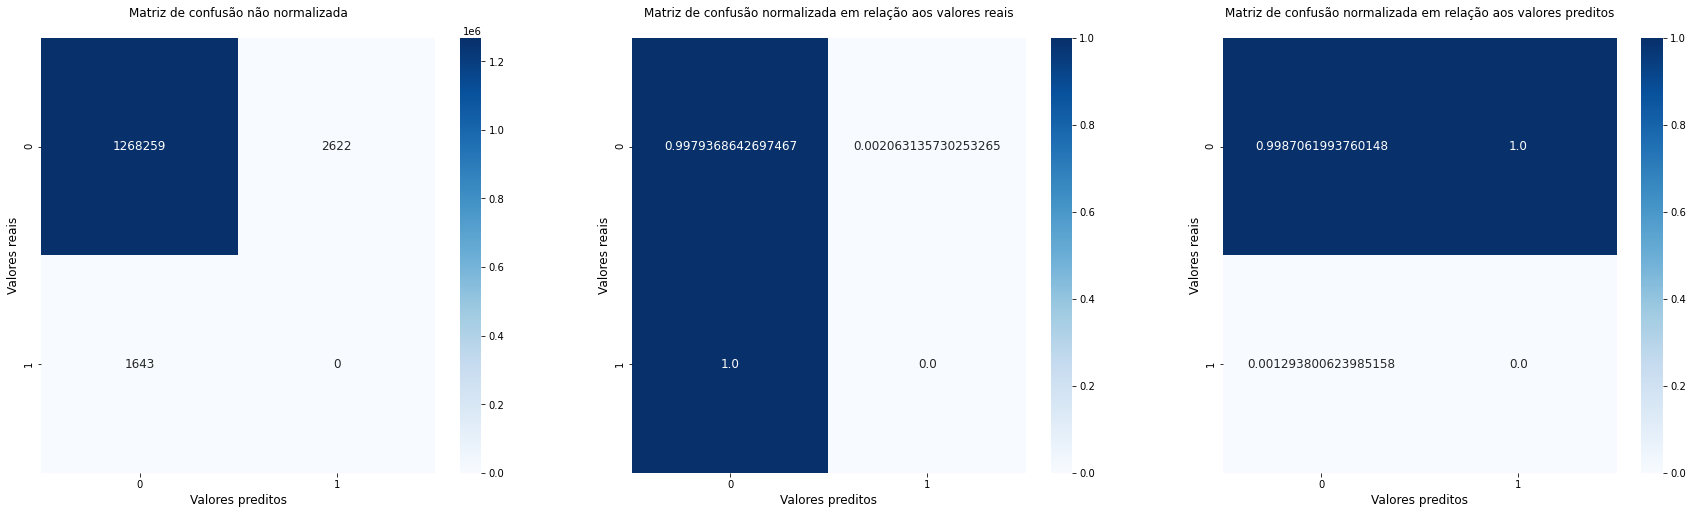

In [ ]:
# Mostrando a acurácia e as confusion matrix
print('Modelo: Naive-Bayes.\n')
show_accuracy_and_confusion_matrix(nb, y_test, nb_y_pred)

Esse modelo é bem ruim, do ponto de vista para o lucro da nossa empresa. Apesar de apresentar uma acurácia de **99,66%**, ele errou todos os FN, ou seja, teríamos que devolver 100% das transações para o banco e não ganharíamos 25% das transações, de acordo com as regras de negócio 3 e 1, respectivamente:

> "A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude."

> "A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude."

Ou seja, mesmo tendo uma acurácia alta, o ***recall* é horrível**.

Mesmo assim, vamos armazenar o modelo em nosso DataFrame de métricas, e analisar se é mais efetivo que os outros algoritmos.


In [ ]:
# Recolhendo as informações para o DataFrame de métricas
nb_metrics = give_ml_stats(nb, y_test, nb_y_pred)
nb_metrics['Model'] = 'Naive-Bayes'

In [ ]:
# Alterando o DataFrame de métricas
models_metrics = models_metrics.append(nb_metrics, ignore_index=True)

#### ***Logistic Regression***

O modelo de Regressão Logística é utilizado para descrever uma variável quantitativa como algo classificatório (binário). O método utiliza a probabililidade de ocorrer tal valor (quantitativo), sendo assim, se for uma probabilidade menor que 50% (conseguimos mudar esse parâmetro), então ele classifica como "não possível" (0), já se for acima, como "possível" (1).

A função que ela utiliza é a **sigmoid**, com a fórmula abaixo:

<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/5e648e1dd38ef843d57777cd34c67465bbca694f"></center>

Dado uma função linear *t*, temos: 

<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/836d93163447344be4715ec00638c1cd829e376c"></center>

Então:

<center><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e376fe69caee24c914fab1360de36900b7bb9c24"></center>



Vai um exemplo abaixo:

<center><img src="https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg"></center>

A função t pode ter várias variáveis independentes, com seus determinados pesos. Ela é facilmente descoberta com algoritmos no python (sklearn), então não precisamos nos atentar com as exigências matemáticas.

In [ ]:
# Treinando o modelo e prevendo valores
lr = LogisticRegression(random_state=0, max_iter=200)
lr.fit(X_train, y_train)

lr_y_pred = lr.predict(X_test)

Modelo: Logistic Regression.

Acurácia: 0.9987214386526305



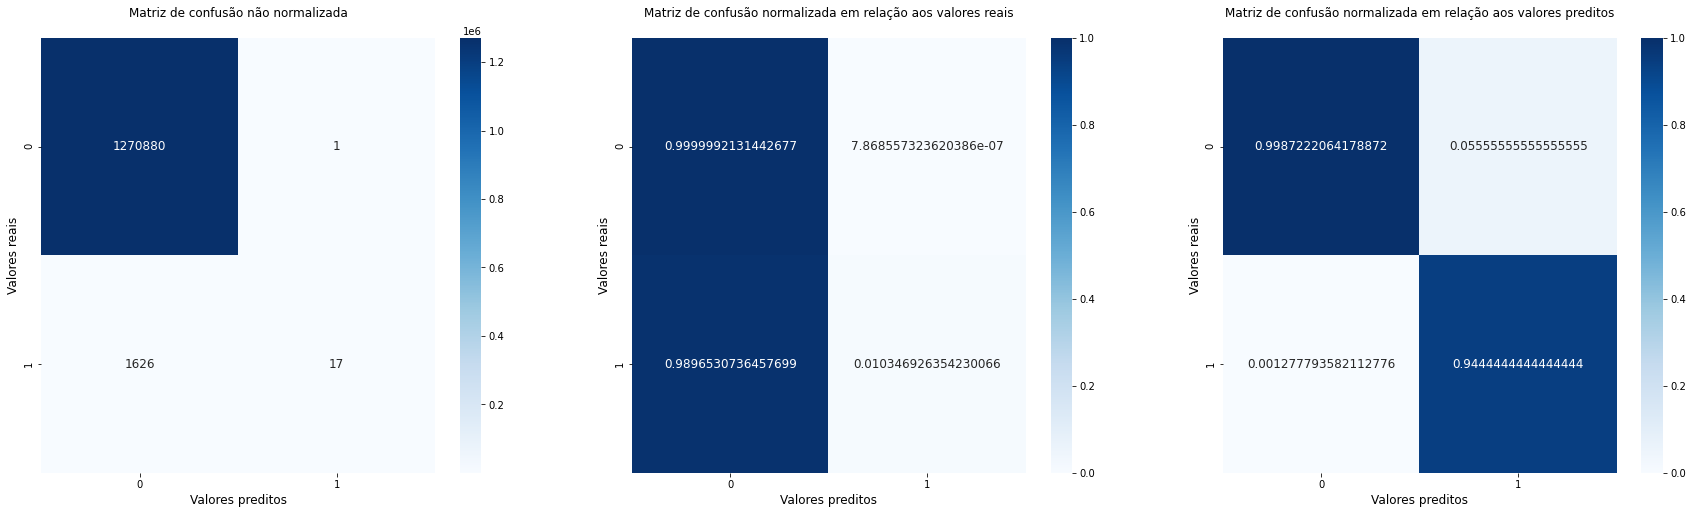

In [ ]:
# Mostrando a acurácia e as confusion matrix
print('Modelo: Logistic Regression.\n')
show_accuracy_and_confusion_matrix(lr, y_test, lr_y_pred)

Nesse modelo temos algo um pouco mais interessante, além de termos uma acurácia um pouco maior e apenas 1 caso de FP, aumentamos em 17 o número de TP. Entretanto, ainda é muito alto os FN, deixando **prejuízos** para a *fintech*.

Vamos guardá-lo para o nosso *DataFrame* com todas as métricas, assim fica mais fácil de comparar com os outros modelos que ainda irão ser testados!

In [ ]:
# Recolhendo as informações para o DataFrame de métricas
lr_metrics = give_ml_stats(lr, y_test, lr_y_pred)
lr_metrics['Model'] = 'Logistic Regression'

In [ ]:
# Alterando o DataFrame de métricas
models_metrics = models_metrics.append(lr_metrics, ignore_index=True)

#### ***Decision Tree Classifier***

Esse algoritmo tenta dividir o nosso treinamento a partir de determinadas condições (*labels* das variáveis independentes), então é como se fosse uma "árvore" se dividindo em várias possibilidades (eventos aleatórios).

O próprio computador consegue saber quais os nós que vão primeiro, deixando muito mais fácil para o usuário do código, no Python (por padrão, o critério de divisão dos ramos no sklearn é o "Gini"). Novamente estamos ignorando a base matemática por trás, e apenas colocando uma visão intuitiva do modelo.

<center><img src="https://uvagpclass.files.wordpress.com/2017/10/whatsapp-image-2017-10-26-at-17-03-37.jpeg?w=736"></center>

Os resultados podem ser diversos, no exemplo acima, poderíamos ter somente 2 resultados possíveis, como é o nosso caso, em que o y predito pode valer 0 ou 1.

No final, utilizamos os dados de treino na nossa árvore já montada, e assim, temos a o y predito.

In [ ]:
# Treinando o modelo e prevendo valores
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

dt_y_pred = dt.predict(X_test)

Modelo: Decision Tree Classifier.

Acurácia: 0.999677805683822



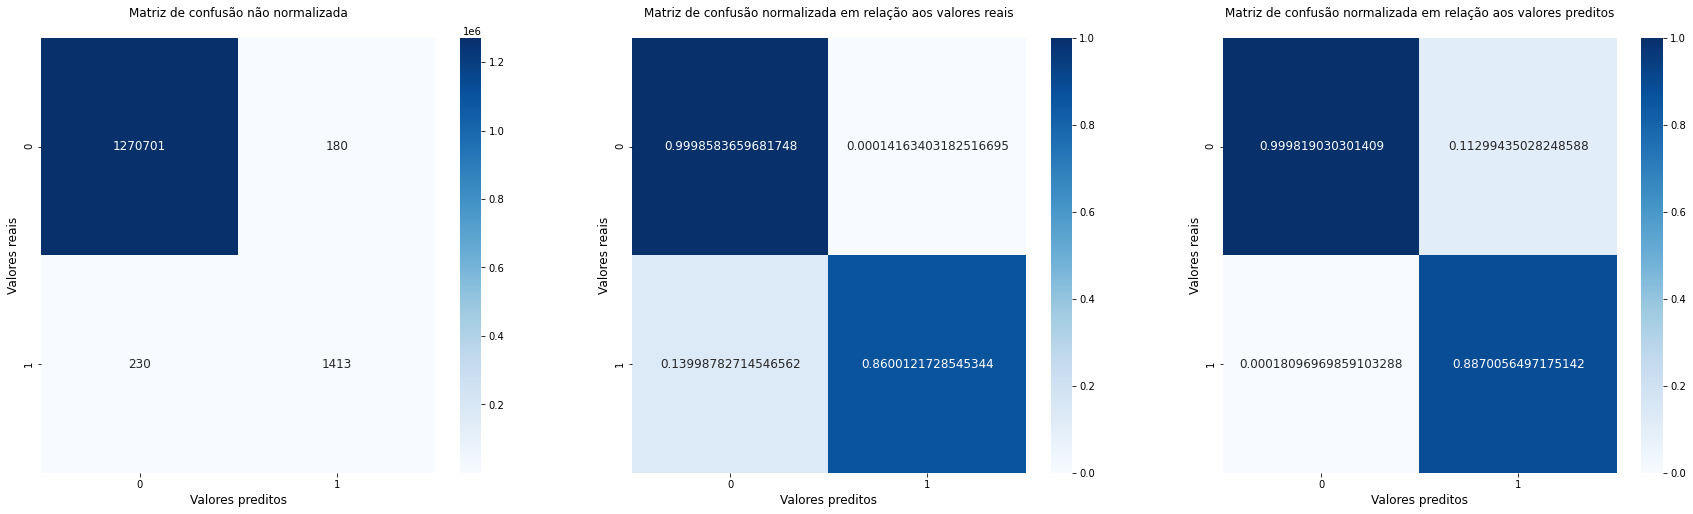

In [ ]:
# Mostrando a acurácia e as confusion matrix
print('Modelo: Decision Tree Classifier.\n')
show_accuracy_and_confusion_matrix(dt, y_test, dt_y_pred)

A acurácia é ainda maior que o modelo anterior, entretanto, a precisão decaiu 5% aproximadamente. 

Olhando para o nosso negócio, com certeza estamos em um caminho muito mais atraente! Pois observe o número de TP e FN, o *recall* desse modelo é de **86%**, uma grande evolução!

Bom, provavelmente este será o melhor modelo testado... Mas enfim, temos o nosso último algoritmo para testar.

In [ ]:
# Recolhendo as informações para o DataFrame de métricas
dt_metrics = give_ml_stats(dt, y_test, dt_y_pred)
dt_metrics['Model'] = 'Decision Tree Classifier'

In [ ]:
# Alterando o DataFrame de métricas
models_metrics = models_metrics.append(dt_metrics, ignore_index=True)

#### ***Random Forest Classifier***

Esse algoritmo utiliza Árvores de Decisão por baixo dos panos. Na verdade, ela usa uma técnica chamada ***Ensemble Learning***, o qual testa vários algoritmos (iguais ou diferentes, no nosso caso são várias árvores diferenciadas entre si) com amostras e colunas distintas (randomizadas).

<center><img src="https://static.packt-cdn.com/products/9781789539462/graphics/5e71f3a8-9402-467c-a9a0-45df99bd4f85.png", width=600></center>

No final, se a **maioria** das árvores apresentar resultados nas predições iguais a 1, por exemplo, então a **predição final** vai ser igual a 1. É esse o funcionamento por trás da *random forest*, de forma intuitiva.

In [ ]:
# Treinando o modelo e prevendo valores
# Prepare-se para esperar bastante tempo rodando essa célula
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)

Modelo: Random Forest Classifier.

Acurácia: 0.9997210268725777



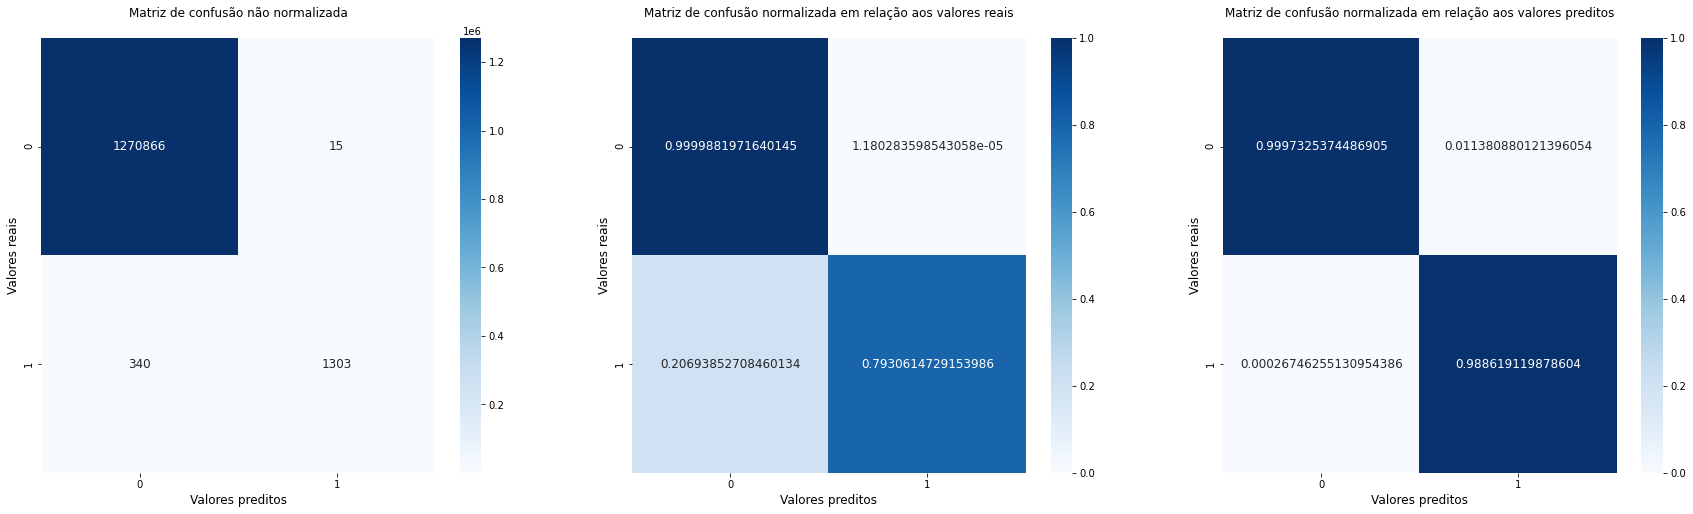

In [ ]:
# Mostrando a acurácia e as confusion matrix
print('Modelo: Random Forest Classifier.\n')
show_accuracy_and_confusion_matrix(rf, y_test, rf_y_pred)

A acurácia da *Random Forest Classifier* está levemente mais alta que a Árvore de Decisão anterior. Porém temos uma *precision* 7,5% maior (**98,64%**), aproximadamente.

Bom, vamos colocar no nosso DataFrame.

In [ ]:
# Recolhendo as informações para o DataFrame de métricas
rf_metrics = give_ml_stats(rf, y_test, rf_y_pred)
rf_metrics['Model'] = 'Random Forest Classifier'

In [ ]:
# Alterando o DataFrame de métricas
models_metrics = models_metrics.append(rf_metrics, ignore_index=True)

### **Um aviso...**

É muito estranho essas acurácias darem valores tão altos nos modelos de *Machine Learning*... Se de fato descobríssemos esses números, por favor NUbank, NUs contrate!

Brincadeiras a parte, o que pode ser uma explicação para esse fenômeno, é a proporção de transações fraudulentas, comparado com as legítimas.

Em nossa análise exploratória, descobrimos que a proporção de fraudes era a seguinte:

In [ ]:
# Proporção de fraudes e não fraudes em porcentagem
df['isFraud'].value_counts(normalize=True) * 100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

Ou seja, para que nossos algoritmos de machine learning tivessem um desempenho mais realístico, o conjunto de dados deveria estar com uma proporção parecida de operações fraudulentas e não fraudulentas, mistificando assim, os nossos resultados encontrados...

Isso é só um aviso! Bom, vamos para a penútima etapa, comparar as métricas!

### **Comparando melhor as métricas**

Agora que temos todas as nossas métricas juntas, vamos olhar como ficou a nossa tabela, além de responder a primeira pergunta que nos foi proposto para o relatório final:

In [ ]:
# Settando o modelo como índice
models_metrics = models_metrics.set_index('Model')

#### **01. Qual a Precisão e Acurácia dos modelos utilizados?**

In [ ]:
# Mostrando os números com mapa de calor
display(models_metrics.style.set_table_attributes("class='dataframe'").background_gradient(cmap='Blues', 
                                                                                           axis=0, subset=models_metrics.columns))

,True Negative,False Positive,False Negative,True Positive,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,,,,,
Naive-Bayes,1268259,2622,1643,0,0.996648,0.000000,0.000000,0.000000,0.728771
Logistic Regression,1270880,1,1626,17,0.998721,0.944444,0.010347,0.020470,0.730448
Decision Tree Classifier,1270701,180,230,1413,0.999678,0.887006,0.860012,0.873300,0.929935
Random Forest Classifier,1270866,15,340,1303,0.999721,0.988619,0.793061,0.880108,0.986614


Vão aqui algumas notas que nos ressaltaram mais:
- ***Naive-Bayes*:**
  - Piores métricas $(-)$.

- ***Logistic Regression*:**
  - Segunda melhor *precision* $(+)$;
  - Terceira melhor acurácia $(-)$;
  - Todas as métricas restantes são ruins $(-)$.

- ***Decision Tree Classifier*:**
  - Melhor *recall* $(+)$;
  - Segunda melhor acurácia e *AUC* $(+)$;
  - Terceira melhor *precision* $(-)$.

- ***Random Forest Classifier*:**
  - Melhores *AUC*, F1-Score, *precision* e acurácia $(+)$;

Okay, mas afinal, qual é considerado o **melhor modelo**? Mais uma pergunta que foi nos proposto no escopo do projeto.

#### **02. Qual dos modelos é o melhor e por quê?**

O melhor modelo é  a ***Decision Tree Classifier***! Isso porque ela foi a que apresentou o **maior *recall*** (0,86) dentre os modelos, ou seja, **para as  regras de negócio da RGBank**, ter o **mínimo de FN** é a melhor opção, assim não precisaríamos devolver 100% dos valores em transação.

Só uma observação, mesmo a Random Forest tendo valores maiores nas outras métricas, **ter o mínimo de FN é muito importante**, além de que os scores das outras medidas não estão tão ruins.

In [ ]:
# Deletando os modelos não utilizados para não sobrecarregar o Colab
del [nb, lr, rf]

### **Testes Finais**

Vamos respoder nessa seção as perguntas finais, junto da regra de negócios! Reelembrando as regras, temos:
1. **A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.**
2. **A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.** 
3. **A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.**

**Observação:** não sabemos a unidade monetária das transações, infelizmente. Sendo assim, os valores podem ser bem expressivos, e também temos a inflação como fator que não podemos mensurar.

Antes de irmos direto para as respostas, temos que verificar a consistência do nosso modelo a longo prazo...

Na descrição dos dados, diz que o *Dataset* em que estamos analisando corresponde a 1/4 das amostras dentro de 31 dias. Sendo assim, como iríamos testar com o restante dos dados de 1 mês (3/4), e prever para os meses futuros se a transação foi fraude ou não, **dado que acertamos com muita eficiência, mas apenas 1/4 do total? O quanto apenas 1/4 de todas as transações no mês são confiáveis para colocarmos o nosso modelo em produção? Será que o lucro para a nossa empresa é bem representativo para este intervalo de tempo?**

Sendo assim, um método especulativo que encontramos é assumir que as nossas transações são **TODOS** os dados de 1 mês, e não apenas 1/4. Ou seja, **estamos assumindo que o nosso *DataFrame* representa muito bem o que acontece, na realidade, em 1 mês!** Desse modo, repetiriamos o mesmo processo feito, ou seja:
1. Dividir os dados em 1/4;
2. Realizar o treinamento e teste destes 1/4, com 80\% de treino e 20\% de teste;
3. Descobrir os valores de negócio para estes 1/4;
4. Expandir o modelo para todo o *Dataset* ("dados de 1 mês inteiro");
5. Verificar o quanto os valores monetários se alteram.

Dependendo do quanto estes variam, poderíamos supor essa variação para a realidade, e tentar assumir isso para nosso resultado final.

Talvez colocando esse processo em prática ficaria mais claro.

In [ ]:
# Ultilizamos o train_test_split pois é mais simples, por conta do stratify
# Vamos pegar 1/4 do nosso dataset
_X , X_test_sample, _y , y_test_sample = train_test_split(X, y, random_state=0,
                                                        stratify=y, test_size=0.25)

In [ ]:
# Deletando as variáveis desnecessárias para não sobrecarregar o Colab
del [_X, _y]

In [ ]:
# Agora, vamos dividir o nosso treinamento e teste em 80-20, apenas 
# utilizando o X_test_sample e o y_test_sample
# Obs: o ss nas variáveis são uma abreviação para "sample of sample"
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_test_sample, y_test_sample, random_state=0, 
                                                                stratify=y_test_sample, test_size=0.2)

A nossa sorte é que, a *Decision Tree Classifier* não precisa de padronização dos dados! Portanto, aplicar o `StandardScaler()` não vai ser necessário para o treinamento do modelo!

In [ ]:
# Treinando a Árvore com a amostra da amostra
dt_2 = DecisionTreeClassifier(random_state=0)
dt_2.fit(X_train_ss, y_train_ss)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
# Resultados de negócio com 1/4 do DataFrame que tínhamos e a Árvore treinada
# com a amostra da amostra
sample_cross_amount, sample_expense, sample_gain = give_business_results(dt_2, X_test_sample, y_test_sample)

In [ ]:
# Resultados de negócio com os X e y do DataFrame inteiro, utilizando o mesmo
# modelo anterior
cross_amount_all_df, expense_all_df, gain_all_df = give_business_results(dt_2, X, y)

In [ ]:
# Deletando o modelo provisório para não sobrecarregar o Colab
del dt_2

O que queremos saber na verdade, para ser bem claro, é se o modelo se dá bem com **MUITOS** dados desconhecidos, pois na vida real, vai ser um número muito maior de transações a longo prazo, mais que apenas 1 mês, e com um volume gigante de dados diários. 

Sendo assim, se nos baseássemos em um aumento diretamente proporcional de transações, tendo determinados valores de faturamento, despesa e lucro, esperaríamos um salto de **400%** em cada um desses números, ou algo próximo a isso.

Reelembrando, estamos considerando que o nosso *DataFrame* inteiro simula todas as transações que tiveram realmente em 1 mês. Vamos verificar se isso acontece com o nosso modelo recentemente criado e os valores passados.

In [ ]:
cross_amount_increase = round(cross_amount_all_df / sample_cross_amount * 100, 2)
expense_increase = round(expense_all_df / sample_expense * 100, 2)
gain_increase = round(gain_all_df / sample_gain * 100, 2)

In [ ]:
print(f'O faturamento cresceu {cross_amount_increase}%.\n')
print(f'O prejuízo cresceu {expense_increase}%.\n')
print(f'O lucro cresceu {gain_increase}%.')

O faturamento cresceu 376.02%.

O prejuízo cresceu 2118.57%.

O lucro cresceu 350.36%.


O prejuízo foi notóriamente aumentado, além de que o faturamento e o lucro não atingiram os 400% que nós estavamos esperando... isto por conta da porcentagem de crescimento do prejuízo.

Mas tudo bem, pelo menos conseguimos algo estimado para o mês inteiro, e era o que estávamos procurando.

Vamos responder as perguntas agora, de acordo com o nosso melhor modelo, aquela primeira *Decision Tree*.

In [ ]:
# Padronizando o nosso X (isso por que o primeiro modelo necessitava 
# da padronização dos dados)
X[:, :5] = sc.transform(X[:, :5])

In [ ]:
# Prevendo todos os dados no modelo
final_y_pred = dt.predict(X)

In [ ]:
# Juntando em uma nova coluna os valores preditos
df['isFraudPrediction'] = final_y_pred
df.head()

,day,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraudPrediction
0,0.0,9839.64,170136.0,160296.36,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.0,1864.28,21249.0,19384.72,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.0,11668.14,41554.0,29885.86,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.0,7817.71,53860.0,46042.29,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0.0,7107.77,183195.0,176087.23,551247.21,683724.79,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### **03. Qual o faturamento esperado pela empresa, se classificarmos 100% das transações, com o melhor modelo?**

Antes, vamos separar em dois outros *DataFrames* com os valores dos *True Positives* (regra 1) e *False Positives* (regra 2).

In [ ]:
# DataFrame dos TP
tp_df = df.query('isFraud == 1 and isFraud == isFraudPrediction')
tp_df.head()

,day,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraudPrediction
2,0.0,181.0,181.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0.0,181.0,181.0,0.0,21182.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
251,0.0,2806.0,2806.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
252,0.0,2806.0,2806.0,0.0,26202.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
680,0.0,20128.0,20128.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [ ]:
# DataFrame dos FP
fp_df = df.query('isFraudPrediction == 1 and isFraud != isFraudPrediction')
fp_df.head()

,day,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraudPrediction
3731,0.0,36563.86,100035.00,136598.86,0.00,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
5749,0.0,11950.98,16083.88,4132.90,615126.57,271152.52,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6072,0.0,18979.27,0.00,0.00,28941.95,47921.23,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6386,0.0,80710.33,64513.03,0.00,15662807.36,15944428.35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6438,0.0,105165.25,65352.75,0.00,8447.67,113612.92,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
# Definindo o faturamento
tp_total = (tp_df['amount'] * 0.25).sum()
fp_total = (fp_df['amount'] * 0.05).sum()

cross_amount = tp_total + fp_total
print(f'O faturamento esperado pela empresa é igual a: {cross_amount}, se considerarmos 1/4 das transações em 1 mês.\n')
print(f'Entretanto, se fossemos deduzir o quanto se aumenta, para 100% das transações mensais, temos a possibilidade de encontrar {round(cross_amount_increase / 100, 2)}x esse valor!')

O faturamento esperado pela empresa é igual a: 3004400679.3964996, se considerarmos 1/4 das transações em 1 mês.

Entretanto, se fossemos deduzir o quanto se aumenta, para 100% das transações mensais, temos a possibilidade de encontrar 3.76x esse valor!


#### **04. Qual o prejuízo esperado pela empresa, se classificarmos 100% das transações, em caso de falha do melhor modelo?**

Se separarmos o *DataFrame* dos *False Negatives* (regra 3), temos:

In [ ]:
# DataFrame dos FN
fn_df = df.query('isFraudPrediction == 0 and isFraud != isFraudPrediction')
fn_df.head()

,day,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraudPrediction
4857,0.0,120074.73,120074.73,0.0,0.00,0.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4858,0.0,120074.73,120074.73,0.0,0.00,120074.73,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5123,0.0,60726.57,60726.57,0.0,0.00,0.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5747,0.0,25975.86,25975.86,0.0,98152.00,28041.27,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9285,0.0,262434.54,262434.54,0.0,19525.79,438233.86,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
expense = fn_df['amount'].sum()
print(f'O prejuízo esperado pela empresa é igual a: {expense}, se considerarmos 1/4 das transações em 1 mês.\n')
print(f'Entretanto, se fossemos deduzir o quanto se aumenta, para 100% das transações mensais, temos a possibilidade de encontrar {round(expense_increase / 100, 2)}x esse valor!')

O prejuízo esperado pela empresa é igual a: 45659154.44, se considerarmos 1/4 das transações em 1 mês.

Entretanto, se fossemos deduzir o quanto se aumenta, para 100% das transações mensais, temos a possibilidade de encontrar 21.19x esse valor!


#### **05. Qual o lucro esperado pela empresa, se classificarmos 100% das transações, ao utilizar o melhor modelo?**

Basta subtrair os valores anteriores!

In [ ]:
gain = cross_amount - expense
print(f'O lucro esperado pela empresa é igual a: {gain}, se considerarmos 1/4 das transações em 1 mês.\n')
print(f'Entretanto, se fossemos deduzir o quanto se aumenta, para 100% das transações mensais, temos a possibilidade de encontrar {round(gain_increase / 100, 2)}x esse valor!')

O lucro esperado pela empresa é igual a: 2958741524.9564996, se considerarmos 1/4 das transações em 1 mês.

Entretanto, se fossemos deduzir o quanto se aumenta, para 100% das transações mensais, temos a possibilidade de encontrar 3.5x esse valor!


#### **Extra**

Para finalizar, vamos ver o quanto das transações TP, FP e FN esse lucro corresponde.

In [ ]:
money_df = pd.concat([tp_df, fp_df, fn_df])
total_amount = money_df['amount'].sum()

In [ ]:
print(f'O lucro esperado equivale a {round((gain / total_amount), 3) * 100}% das transações TP, FP e FN.')

O lucro esperado equivale a 24.5% das transações TP, FP e FN.
